In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf

/Users/paulag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array(nino34['nino34'].values)

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


In [3]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [4]:
oni = ONI(nino34)

In [5]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [6]:
clm = climatology(nino34)

In [7]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [8]:
anm = SST_anomaly(nino34, clm)
oanm = ONI(anm)

In [18]:
T = 6                       # prediction timeline
H = 48                      # history used for prediction
n_classes = 3               # number of classes (El Nino, El Nina, No Event)
threshold = 0.5         
signal = np.array(nino34[12 * 50:])   # data used for training/testing
length = signal.shape[0]    # number of data points
size = length - H - T       # effective dataset size

In [19]:
# create the 'history matrix'
data = np.ndarray((size, H))
for i in range(size):
    data[i] = signal[i:(i + H)]

# label El Nino as 2, El Nina as 0 and no event as 1
labels = np.ndarray((size))
for i in range(length - H - T):
    if(oanm[i + H + T] >= threshold):
        labels[i] = 2
    elif(oanm[i + H + T] <= -threshold):
        labels[i] = 0
    else:
        labels[i] = 1

In [20]:
np.random.seed(0)

size2 = size // 12
acc_m = np.zeros(12)
loss_m = np.zeros(12)

month = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

for m in range(12):
    
    split = size2 // 10      
    shuffle = 12 * np.random.permutation(size2) + m * np.ones(size2, dtype = int)
    
    train_ind = np.array(shuffle[0: 8 * split])
    val_ind = np.array(shuffle[(8 * split + 1): 9 * split])
    test_ind = np.array(shuffle[(9 * split + 1): size])

    train = np.array(data[train_ind])
    train_labels = np.array(labels[train_ind])

    val = np.array(data[val_ind])
    val_labels = np.array(labels[val_ind])

    test = np.array(data[test_ind])
    test_labels = np.array(labels[test_ind])
    
    mean = np.mean(train, axis = 0)
    std = np.std(train, axis = 0)

    train_n = np.divide(
        train - np.outer(np.ones(train.shape[0]), mean),
        np.outer(np.ones(train.shape[0]), std))

    val_n = np.divide(
        val - np.outer(np.ones(val.shape[0]), mean),
        np.outer(np.ones(val.shape[0]), std))

    test_n = np.divide(
        test - np.outer(np.ones(test.shape[0]), mean),
        np.outer(np.ones(test.shape[0]), std))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        encoded_train_labels = tf.one_hot(train_labels, depth = n_classes).eval()
        encoded_val_labels = tf.one_hot(val_labels, depth = n_classes).eval()
        encoded_test_labels = tf.one_hot(test_labels, depth = n_classes).eval()
        
    (d, N1, N2, N3) = (0.3, 768, 768, 384)
    epochs = 60
        
    model = tf.keras.models.Sequential([
              tf.keras.layers.Dense(N1, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N2, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N3, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
            ])

    model.reset_states()

    model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    model.fit(train_n, encoded_train_labels, epochs = epochs, verbose = 0)
    (loss_m[m], acc_m[m]) = model.evaluate(val_n, encoded_val_labels, verbose = 0)
        
    print("Accuracy on", month[m], ":", acc_m[m])

Accuracy on Jan : 0.4655172444623092
Accuracy on Feb : 0.5000000010276663
Accuracy on Mar : 0.43103448686928586
Accuracy on Apr : 0.48275862377265405
Accuracy on May : 0.3965517261932636
Accuracy on June : 0.25862069222433814
Accuracy on July : 0.3448275903175617
Accuracy on Aug : 0.3448275887760623
Accuracy on Sep : 0.37931034996591767
Accuracy on Oct : 0.41379310344827586
Accuracy on Nov : 0.3448275903175617
Accuracy on Dec : 0.4310344848139533


# Trying a simpler architecture

In [21]:
np.random.seed(0)

size2 = size // 12
acc_m = np.zeros(12)
loss_m = np.zeros(12)

month = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

for m in range(12):
    
    split = size2 // 10      
    shuffle = 12 * np.random.permutation(size2) + m * np.ones(size2, dtype = int)
    
    train_ind = np.array(shuffle[0: 8 * split])
    val_ind = np.array(shuffle[(8 * split + 1): 9 * split])
    test_ind = np.array(shuffle[(9 * split + 1): size])

    train = np.array(data[train_ind])
    train_labels = np.array(labels[train_ind])

    val = np.array(data[val_ind])
    val_labels = np.array(labels[val_ind])

    test = np.array(data[test_ind])
    test_labels = np.array(labels[test_ind])
    
    mean = np.mean(train, axis = 0)
    std = np.std(train, axis = 0)

    train_n = np.divide(
        train - np.outer(np.ones(train.shape[0]), mean),
        np.outer(np.ones(train.shape[0]), std))

    val_n = np.divide(
        val - np.outer(np.ones(val.shape[0]), mean),
        np.outer(np.ones(val.shape[0]), std))

    test_n = np.divide(
        test - np.outer(np.ones(test.shape[0]), mean),
        np.outer(np.ones(test.shape[0]), std))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        encoded_train_labels = tf.one_hot(train_labels, depth = n_classes).eval()
        encoded_val_labels = tf.one_hot(val_labels, depth = n_classes).eval()
        encoded_test_labels = tf.one_hot(test_labels, depth = n_classes).eval()
        
    (d, N1, N2) = (0.2, 196, 384)
    epochs = 30
        
    model = tf.keras.models.Sequential([
              tf.keras.layers.Dense(N1, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N2, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
            ])

    model.reset_states()

    model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    model.fit(train_n, encoded_train_labels, epochs = epochs, verbose = 0)
    (loss_m[m], acc_m[m]) = model.evaluate(val_n, encoded_val_labels, verbose = 0)
        
    print("Accuracy on", month[m], ":", acc_m[m])

Accuracy on Jan : 0.4310344858416196
Accuracy on Feb : 0.41379311578027134
Accuracy on Mar : 0.41379310447594214
Accuracy on Apr : 0.3965517282485962
Accuracy on May : 0.24137931445549274
Accuracy on June : 0.2241379325759822
Accuracy on July : 0.3448275903175617
Accuracy on Aug : 0.24137931188632702
Accuracy on Sep : 0.3103448337522046
Accuracy on Oct : 0.3793103489382514
Accuracy on Nov : 0.3793103458552525
Accuracy on Dec : 0.43103448686928586


# Trying a deeper architecture

In [22]:
np.random.seed(0)

size2 = size // 12
acc_m = np.zeros(12)
loss_m = np.zeros(12)

month = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

for m in range(12):
    
    split = size2 // 10      
    shuffle = 12 * np.random.permutation(size2) + m * np.ones(size2, dtype = int)
    
    train_ind = np.array(shuffle[0: 8 * split])
    val_ind = np.array(shuffle[(8 * split + 1): 9 * split])
    test_ind = np.array(shuffle[(9 * split + 1): size])

    train = np.array(data[train_ind])
    train_labels = np.array(labels[train_ind])

    val = np.array(data[val_ind])
    val_labels = np.array(labels[val_ind])

    test = np.array(data[test_ind])
    test_labels = np.array(labels[test_ind])
    
    mean = np.mean(train, axis = 0)
    std = np.std(train, axis = 0)

    train_n = np.divide(
        train - np.outer(np.ones(train.shape[0]), mean),
        np.outer(np.ones(train.shape[0]), std))

    val_n = np.divide(
        val - np.outer(np.ones(val.shape[0]), mean),
        np.outer(np.ones(val.shape[0]), std))

    test_n = np.divide(
        test - np.outer(np.ones(test.shape[0]), mean),
        np.outer(np.ones(test.shape[0]), std))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        encoded_train_labels = tf.one_hot(train_labels, depth = n_classes).eval()
        encoded_val_labels = tf.one_hot(val_labels, depth = n_classes).eval()
        encoded_test_labels = tf.one_hot(test_labels, depth = n_classes).eval()
        
    (d, N1, N2, N3) = (0.5, 1536, 768, 768)
    epochs = 100
        
    model = tf.keras.models.Sequential([
              tf.keras.layers.Dense(N1, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N2, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N3, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
            ])

    model.reset_states()

    model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    model.fit(train_n, encoded_train_labels, epochs = epochs, verbose = 0)
    (loss_m[m], acc_m[m]) = model.evaluate(val_n, encoded_val_labels, verbose = 0)
        
    print("Accuracy on", month[m], ":", acc_m[m])

Accuracy on Jan : 0.4482758651519644
Accuracy on Feb : 0.5344827586206896
Accuracy on Mar : 0.4310344848139533
Accuracy on Apr : 0.3448275903175617
Accuracy on May : 0.172413795672614
Accuracy on June : 0.2931034508450278
Accuracy on July : 0.20689655223797107
Accuracy on Aug : 0.2931034534141935
Accuracy on Sep : 0.36206896654490767
Accuracy on Oct : 0.4655172434346429
Accuracy on Nov : 0.4482758641242981
Accuracy on Dec : 0.48275861863432257


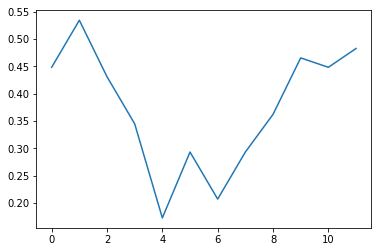

In [25]:
plt.plot(acc_m[:12]);

# Trying larger H

In [26]:
T = 6                       # prediction timeline
H = 60                      # history used for prediction
n_classes = 3               # number of classes (El Nino, El Nina, No Event)
threshold = 0.5         
signal = np.array(nino34[12 * 50:])   # data used for training/testing
length = signal.shape[0]    # number of data points
size = length - H - T       # effective dataset size

In [27]:
# create the 'history matrix'
data = np.ndarray((size, H))
for i in range(size):
    data[i] = signal[i:(i + H)]

# label El Nino as 2, El Nina as 0 and no event as 1
labels = np.ndarray((size))
for i in range(length - H - T):
    if(oanm[i + H + T] >= threshold):
        labels[i] = 2
    elif(oanm[i + H + T] <= -threshold):
        labels[i] = 0
    else:
        labels[i] = 1

In [28]:
np.random.seed(0)

size2 = size // 12
acc_m = np.zeros(12)
loss_m = np.zeros(12)

month = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

for m in range(12):
    
    split = size2 // 10      
    shuffle = 12 * np.random.permutation(size2) + m * np.ones(size2, dtype = int)
    
    train_ind = np.array(shuffle[0: 8 * split])
    val_ind = np.array(shuffle[(8 * split + 1): 9 * split])
    test_ind = np.array(shuffle[(9 * split + 1): size])

    train = np.array(data[train_ind])
    train_labels = np.array(labels[train_ind])

    val = np.array(data[val_ind])
    val_labels = np.array(labels[val_ind])

    test = np.array(data[test_ind])
    test_labels = np.array(labels[test_ind])
    
    mean = np.mean(train, axis = 0)
    std = np.std(train, axis = 0)

    train_n = np.divide(
        train - np.outer(np.ones(train.shape[0]), mean),
        np.outer(np.ones(train.shape[0]), std))

    val_n = np.divide(
        val - np.outer(np.ones(val.shape[0]), mean),
        np.outer(np.ones(val.shape[0]), std))

    test_n = np.divide(
        test - np.outer(np.ones(test.shape[0]), mean),
        np.outer(np.ones(test.shape[0]), std))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        encoded_train_labels = tf.one_hot(train_labels, depth = n_classes).eval()
        encoded_val_labels = tf.one_hot(val_labels, depth = n_classes).eval()
        encoded_test_labels = tf.one_hot(test_labels, depth = n_classes).eval()
        
    (d, N1, N2, N3) = (0.3, 768, 768, 384)
    epochs = 60
        
    model = tf.keras.models.Sequential([
              tf.keras.layers.Dense(N1, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N2, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N3, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
            ])

    model.reset_states()

    model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    model.fit(train_n, encoded_train_labels, epochs = epochs, verbose = 0)
    (loss_m[m], acc_m[m]) = model.evaluate(val_n, encoded_val_labels, verbose = 0)
        
    print("Accuracy on", month[m], ":", acc_m[m])

Accuracy on Jan : 0.6206896510617487
Accuracy on Feb : 0.5172413803380111
Accuracy on Mar : 0.46551724137931033
Accuracy on Apr : 0.31034482912770633
Accuracy on May : 0.2586206901690056
Accuracy on June : 0.3103448337522046
Accuracy on July : 0.344827591345228
Accuracy on Aug : 0.32758621100721685
Accuracy on Sep : 0.3620689706555728
Accuracy on Oct : 0.3275862120348832
Accuracy on Nov : 0.32758621100721685
Accuracy on Dec : 0.31034483169687205


# Fixing Season Instead of Month

In [31]:
T = 6                       # prediction timeline
H = 60                      # history used for prediction
n_classes = 3               # number of classes (El Nino, El Nina, No Event)
threshold = 0.5         
signal = np.array(nino34[12 * 50:])   # data used for training/testing
length = signal.shape[0]    # number of data points
size = length - H - T       # effective dataset size

In [32]:
# create the 'history matrix'
data = np.ndarray((size, H))
for i in range(size):
    data[i] = signal[i:(i + H)]

# label El Nino as 2, El Nina as 0 and no event as 1
labels = np.ndarray((size))
for i in range(length - H - T):
    if(oanm[i + H + T] >= threshold):
        labels[i] = 2
    elif(oanm[i + H + T] <= -threshold):
        labels[i] = 0
    else:
        labels[i] = 1

In [40]:
np.random.seed(0)

size3 = size // 12
acc_s = np.zeros(4)
loss_s = np.zeros(4)

season = ["Winter", "Spring", "Summer", "Fall"]

for s in range(4):
    
    split = (size3 * 3) // 10   
    shuffle = np.zeros(size3 * 3, dtype = int)
    
    # Winter
    if(s == 0):
        shuffle[: size3] = 12 * np.random.permutation(size3) + 11 * np.ones(size3, dtype = int) # december
        shuffle[2*size3 :] = 12 * np.random.permutation(size3) + np.ones(size3, dtype = int) # february
        
    # Spring
    if(s == 1):
        shuffle[: size3] = 12 * np.random.permutation(size3) + 2 * np.ones(size3, dtype = int) # march
        shuffle[size3 : 2 * size3] = 12 * np.random.permutation(size3) + 3 * np.ones(size3, dtype = int) # april
        shuffle[2 * size3 :] = 12 * np.random.permutation(size3) + 4 * np.ones(size3, dtype = int) # may
        
    # Summer
    if(s == 2):
        shuffle[: size3] = 12 * np.random.permutation(size3) + 5 * np.ones(size3, dtype = int) # jun
        shuffle[size3 : 2 * size3] = 12 * np.random.permutation(size3) + 6 * np.ones(size3, dtype = int) # jul
        shuffle[2 * size3 :] = 12 * np.random.permutation(size3) + 7 * np.ones(size3, dtype = int) # aug
        
    # Fall
    if(s == 3):
        shuffle[: size3] = 12 * np.random.permutation(size3) + 8 * np.ones(size3, dtype = int) # sep
        shuffle[size3 : 2 * size3] = 12 * np.random.permutation(size3) + 9 * np.ones(size3, dtype = int) # oct
        shuffle[2 * size3 :] = 12 * np.random.permutation(size3) + 10 * np.ones(size3, dtype = int) # nov
    
    train_ind = np.array(shuffle[0: 8 * split])
    val_ind = np.array(shuffle[8 * split : 9 * split])
    test_ind = np.array(shuffle[9 * split :])

    train = np.array(data[train_ind])
    train_labels = np.array(labels[train_ind])

    val = np.array(data[val_ind])
    val_labels = np.array(labels[val_ind])

    test = np.array(data[test_ind])
    test_labels = np.array(labels[test_ind])
    
    mean = np.mean(train, axis = 0)
    std = np.std(train, axis = 0)

    train_n = np.divide(
        train - np.outer(np.ones(train.shape[0]), mean),
        np.outer(np.ones(train.shape[0]), std))

    val_n = np.divide(
        val - np.outer(np.ones(val.shape[0]), mean),
        np.outer(np.ones(val.shape[0]), std))

    test_n = np.divide(
        test - np.outer(np.ones(test.shape[0]), mean),
        np.outer(np.ones(test.shape[0]), std))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        encoded_train_labels = tf.one_hot(train_labels, depth = n_classes).eval()
        encoded_val_labels = tf.one_hot(val_labels, depth = n_classes).eval()
        encoded_test_labels = tf.one_hot(test_labels, depth = n_classes).eval()
        
    (d, N1, N2, N3) = (0.3, 768, 768, 384)
    epochs = 60
        
    model = tf.keras.models.Sequential([
              tf.keras.layers.Dense(N1, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N2, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N3, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
            ])

    model.reset_states()

    model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    model.fit(train_n, encoded_train_labels, epochs = epochs, verbose = 0)
    (loss_s[s], acc_s[s]) = model.evaluate(val_n, encoded_val_labels, verbose = 0)
        
    print("Accuracy on", season[s], ":", acc_s[s])

Accuracy on Winter : 0.47191011302926567
Accuracy on Spring : 0.668539327851842
Accuracy on Summer : 0.6123595498920826
Accuracy on Fall : 0.6235955042785473
